Read/Tidy results from PCA-SIFT Training

In [1]:
import pickle
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
TOP_10_CATS_ID = set([1,  3, 62, 84, 44, 47, 67, 51, 10, 31])
CATS_NAMES = {
    1: 'person',
    3: 'car',
    62: 'chair',
    84: 'book',
    44: 'bottle',
    47: 'cup',
    67: 'dinning table',
    51: 'traffic light',
    10: 'bowl',
    31: 'handbag'
}
LABELS = [CATS_NAMES[id] for id in sorted(list(TOP_10_CATS_ID))]

In [3]:
model_name_list = [
    'resnet50', 'efficientnet-b0', 'efficientnet-b4'
]
model_time_list = [
    datetime(2025, 4, 26, 12, 35, 56), datetime(2025, 4, 26, 9, 38, 11), datetime(2025, 4, 26, 15, 3, 22)
]

In [4]:
sample_top_model_dir = Path(f'models_coco/{model_name_list[0]}/{model_time_list[0].strftime("%Y%m%d-%H%M%S")}/')

if not sample_top_model_dir.exists():
    raise FileNotFoundError(f"Directory {sample_top_model_dir} does not exist.")

In [5]:
# go through all directories in the top_model_dir to build the hyperparameter grid for us
# assume there are KMeans and PCA N components as hyperparameters

def get_hyperparameter_grid(top_model_dir):
    hyperparameter_grid = []
    for model_dir in top_model_dir.iterdir():
        if not model_dir.is_dir():
            continue
        # get the batch size
        batch_size = int(model_dir.name.split('_')[1])
        # get the learning rate
        learning_rate = float(model_dir.name.split('_')[3])
        # add to the hyperparameter grid
        hyperparameter_grid.append((batch_size, learning_rate))
    return hyperparameter_grid

hyperparameter_grid = sorted(get_hyperparameter_grid(sample_top_model_dir))
hyperparameter_grid

[(8, 1e-05),
 (8, 5e-05),
 (8, 0.0001),
 (16, 1e-05),
 (16, 5e-05),
 (16, 0.0001),
 (32, 1e-05),
 (32, 5e-05),
 (32, 0.0001)]

In [6]:
# create a dataframe to store the results
# we are interested in weighted acc of all models in test and evaluation sets
# and weighted F1 score on both sets

df_testset_dict = {'model': [], 'batch_size':[], 'learning_rate':[], 'weighted_acc':[], 'weighted_f1':[]}
df_evalset_dict = {'model': [], 'batch_size': [], 'learning_rate': [], 'weighted_acc':[], 'weighted_f1':[]}

In [7]:
# we loop through the hyperparameter grid
# visit the directory
# grab the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
# and load them
# then we calculate the weighted acc and f1 score

import numpy as np
from sklearn.metrics import classification_report, balanced_accuracy_score

def calculate_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    acc = report['accuracy']
    weighted_acc = balanced_accuracy_score(y_true, y_pred)
    weighted_f1 = report['weighted avg']['f1-score']
    return acc, weighted_acc, weighted_f1

for model_name, model_time in zip(model_name_list, model_time_list):
    # create the model directory
    top_model_dir = Path(f'models_coco/{model_name}/{model_time.strftime("%Y%m%d-%H%M%S")}/')
    if not top_model_dir.exists():
        raise FileNotFoundError(f"Directory {top_model_dir} does not exist.")
    print(f'Visiting {top_model_dir}')

    for batch_size, learning_rate in hyperparameter_grid:
        # visit the directory
        model_dir = top_model_dir / f'bs_{batch_size}_lr_{learning_rate}'
        if not model_dir.exists():
            continue
        # load the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
        y_test = np.load(model_dir / f'y_labels_test.npy')
        y_pred_test = np.load(model_dir / f'y_pred_test.npy')
        y_eval = np.load(model_dir / f'y_labels_valid.npy')
        y_pred_eval = np.load(model_dir / f'y_pred_valid.npy')

        # calculate the metrics
        acc_test, weighted_acc_test, weighted_f1_test = calculate_metrics(y_test, y_pred_test)
        acc_eval, weighted_acc_eval, weighted_f1_eval = calculate_metrics(y_eval, y_pred_eval)

        print('---' * 20)
        print(f'Batch size: {batch_size}, Learning Rate: {learning_rate}')
        print(f'Weighted Acc Test: {weighted_acc_test}, Weighted F1 Test: {weighted_f1_test}')
        print(f'Weighted Acc Eval: {weighted_acc_eval}, Weighted F1 Eval: {weighted_f1_eval}')
        print('---' * 20)

        # add to the dictionaries
        df_testset_dict['model'].append(model_name)
        df_testset_dict['batch_size'].append(batch_size)
        df_testset_dict['learning_rate'].append(learning_rate)
        df_testset_dict['weighted_acc'].append(weighted_acc_test)
        df_testset_dict['weighted_f1'].append(weighted_f1_test)

        df_evalset_dict['model'].append(model_name)
        df_evalset_dict['batch_size'].append(batch_size)
        df_evalset_dict['learning_rate'].append(learning_rate)
        df_evalset_dict['weighted_acc'].append(weighted_acc_eval)
        df_evalset_dict['weighted_f1'].append(weighted_f1_eval)

# create the dataframes
df_testset = pd.DataFrame(df_testset_dict)
df_evalset = pd.DataFrame(df_evalset_dict)


Visiting models_coco/resnet50/20250426-123556
------------------------------------------------------------
Batch size: 8, Learning Rate: 1e-05
Weighted Acc Test: 0.8300492161251313, Weighted F1 Test: 0.8731510517924554
Weighted Acc Eval: 0.7791981695821821, Weighted F1 Eval: 0.8616823829338471
------------------------------------------------------------
------------------------------------------------------------
Batch size: 8, Learning Rate: 5e-05
Weighted Acc Test: 0.8299876934830863, Weighted F1 Test: 0.8713516622796316
Weighted Acc Eval: 0.7776793248512054, Weighted F1 Eval: 0.8627961669930748
------------------------------------------------------------
------------------------------------------------------------
Batch size: 8, Learning Rate: 0.0001
Weighted Acc Test: 0.8039815208702938, Weighted F1 Test: 0.8582281016068336
Weighted Acc Eval: 0.7565600890691877, Weighted F1 Eval: 0.8543413952101722
------------------------------------------------------------
-----------------------

In [8]:
df_testset

,model,batch_size,learning_rate,weighted_acc,weighted_f1
0,resnet50,8,0.00001,0.830049,0.873151
1,resnet50,8,0.00005,0.829988,0.871352
2,resnet50,8,0.00010,0.803982,0.858228
3,resnet50,16,0.00001,0.838846,0.882373
4,resnet50,16,0.00005,0.821782,0.873354
5,resnet50,16,0.00010,0.808071,0.866114
6,resnet50,32,0.00001,0.825517,0.876134
7,resnet50,32,0.00005,0.833771,0.881780
8,resnet50,32,0.00010,0.829132,0.872014
9,efficientnet-b0,8,0.00001,0.857718,0.888769


In [9]:
df_evalset

,model,batch_size,learning_rate,weighted_acc,weighted_f1
0,resnet50,8,0.00001,0.779198,0.861682
1,resnet50,8,0.00005,0.777679,0.862796
2,resnet50,8,0.00010,0.756560,0.854341
3,resnet50,16,0.00001,0.791517,0.873763
4,resnet50,16,0.00005,0.768208,0.865226
5,resnet50,16,0.00010,0.748919,0.859293
6,resnet50,32,0.00001,0.767418,0.868743
7,resnet50,32,0.00005,0.779199,0.871142
8,resnet50,32,0.00010,0.771940,0.859559
9,efficientnet-b0,8,0.00001,0.803796,0.873422


In [10]:
# sort the dataframes by weighted f1 score
df_testset.sort_values(by='weighted_f1', ascending=False)

,model,batch_size,learning_rate,weighted_acc,weighted_f1
22,efficientnet-b4,16,0.00005,0.873937,0.910548
25,efficientnet-b4,32,0.00005,0.880433,0.910528
23,efficientnet-b4,16,0.00010,0.878834,0.910453
26,efficientnet-b4,32,0.00010,0.873690,0.908665
20,efficientnet-b4,8,0.00010,0.871007,0.905415
19,efficientnet-b4,8,0.00005,0.869656,0.904605
18,efficientnet-b4,8,0.00001,0.862525,0.898442
17,efficientnet-b0,32,0.00010,0.857669,0.897885
21,efficientnet-b4,16,0.00001,0.858200,0.897715
16,efficientnet-b0,32,0.00005,0.859206,0.897211


In [28]:
df_evalset.sort_values(by='weighted_f1', ascending=False)

,model,batch_size,learning_rate,weighted_acc,weighted_f1
23,efficientnet-b4,16,0.00010,0.842049,0.901318
19,efficientnet-b4,8,0.00005,0.837803,0.901225
22,efficientnet-b4,16,0.00005,0.832691,0.900950
25,efficientnet-b4,32,0.00005,0.842641,0.900737
26,efficientnet-b4,32,0.00010,0.833094,0.900298
20,efficientnet-b4,8,0.00010,0.830255,0.899779
18,efficientnet-b4,8,0.00001,0.823728,0.893671
21,efficientnet-b4,16,0.00001,0.812958,0.893260
13,efficientnet-b0,16,0.00005,0.809137,0.887617
24,efficientnet-b4,32,0.00001,0.805483,0.886703


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the results as dot plots

def plot_results(df, title, x, y, x_label, y_label):
    plt.figure(figsize=(12, 6), dpi=300)
    sns.lineplot(data=df, x=x, y=y, hue='model', style='batch_size', markers=['o', 's', 'D'], legend='auto')
    plt.title(f'{title}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(df[x].unique(), labels=df[x].unique())
    plt.grid()
    plt.show()


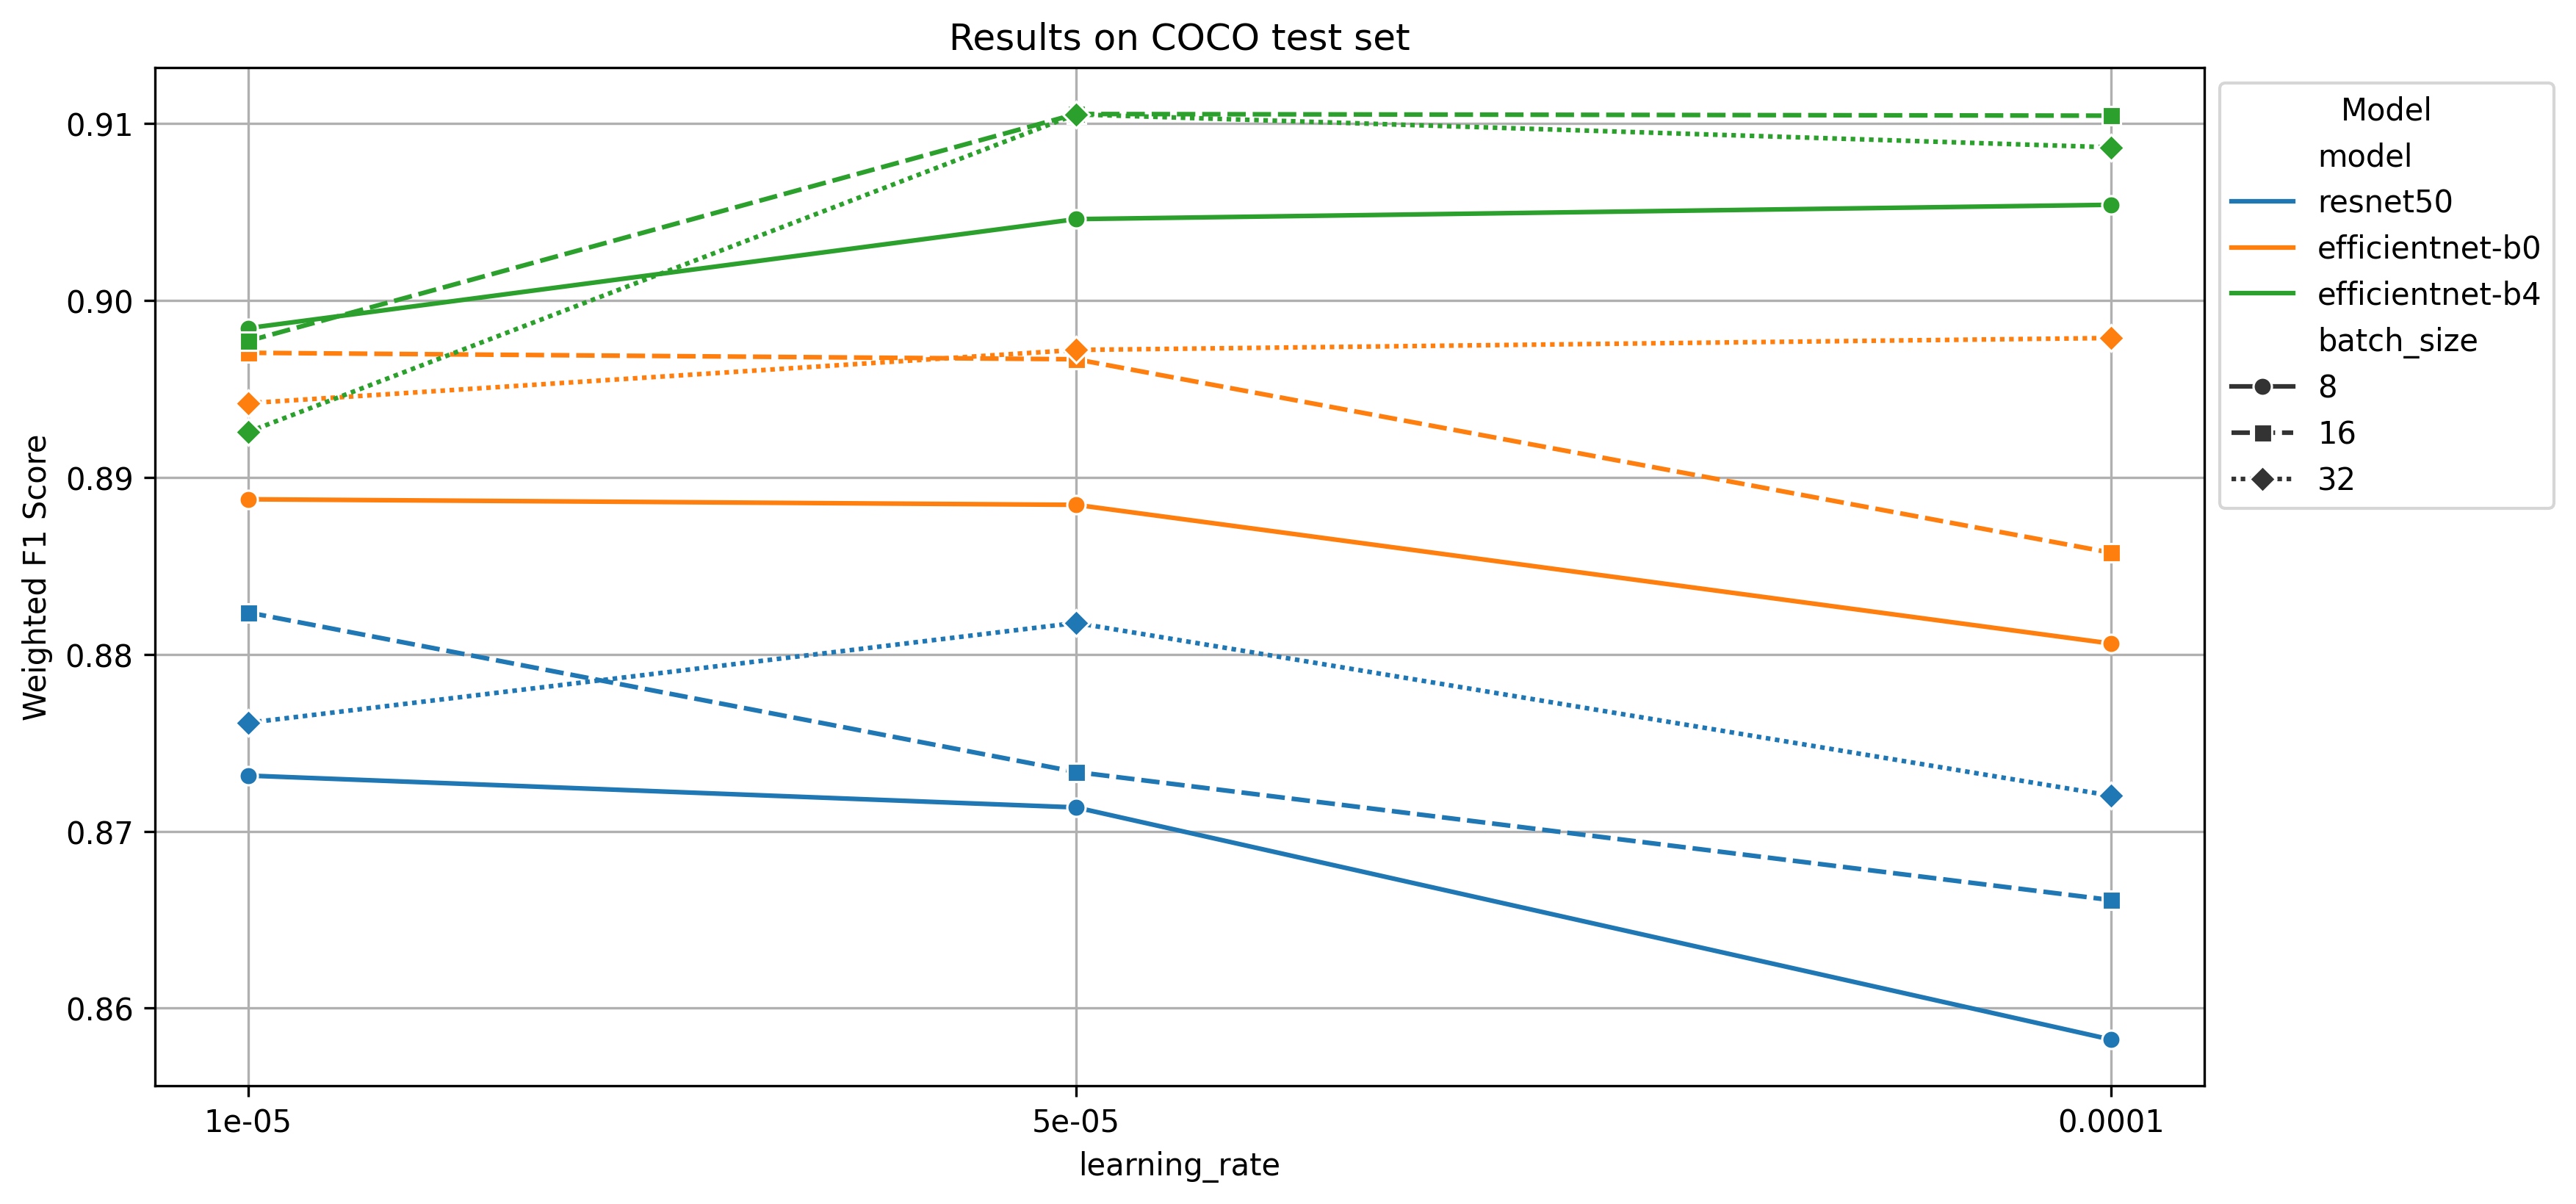

In [ ]:
plot_results(df_testset, 'Results on COCO test set', 'learning_rate', 'weighted_f1', 'learning_rate', 'Weighted F1 Score')

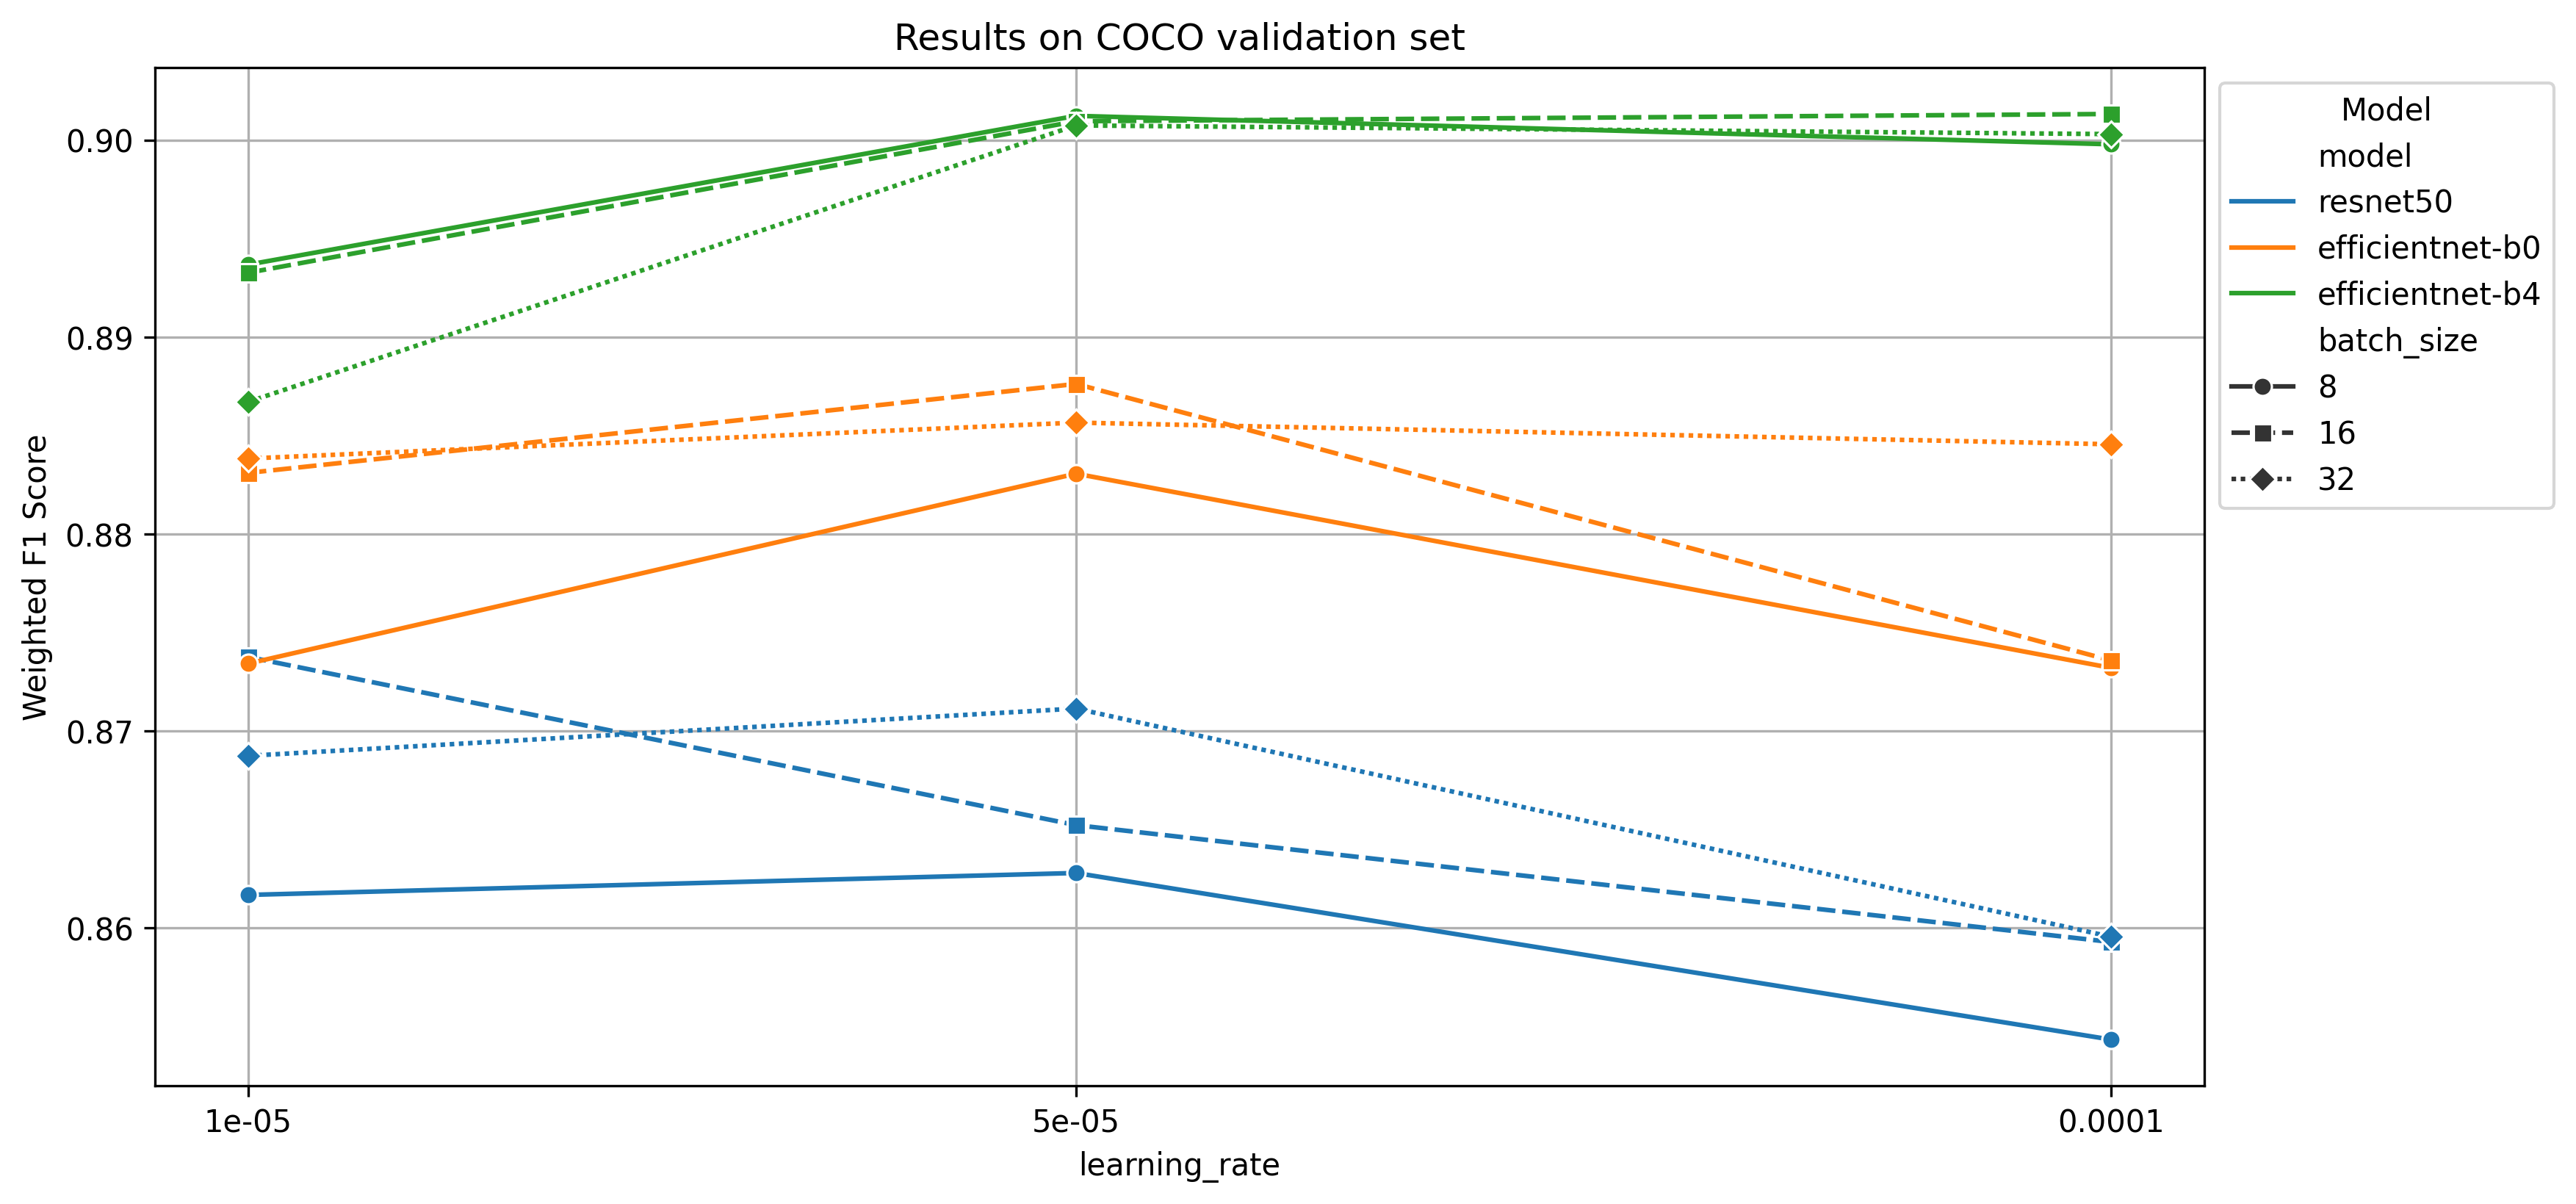

In [14]:
plot_results(df_evalset, 'Results on COCO validation set', 'learning_rate', 'weighted_f1', 'learning_rate', 'Weighted F1 Score')

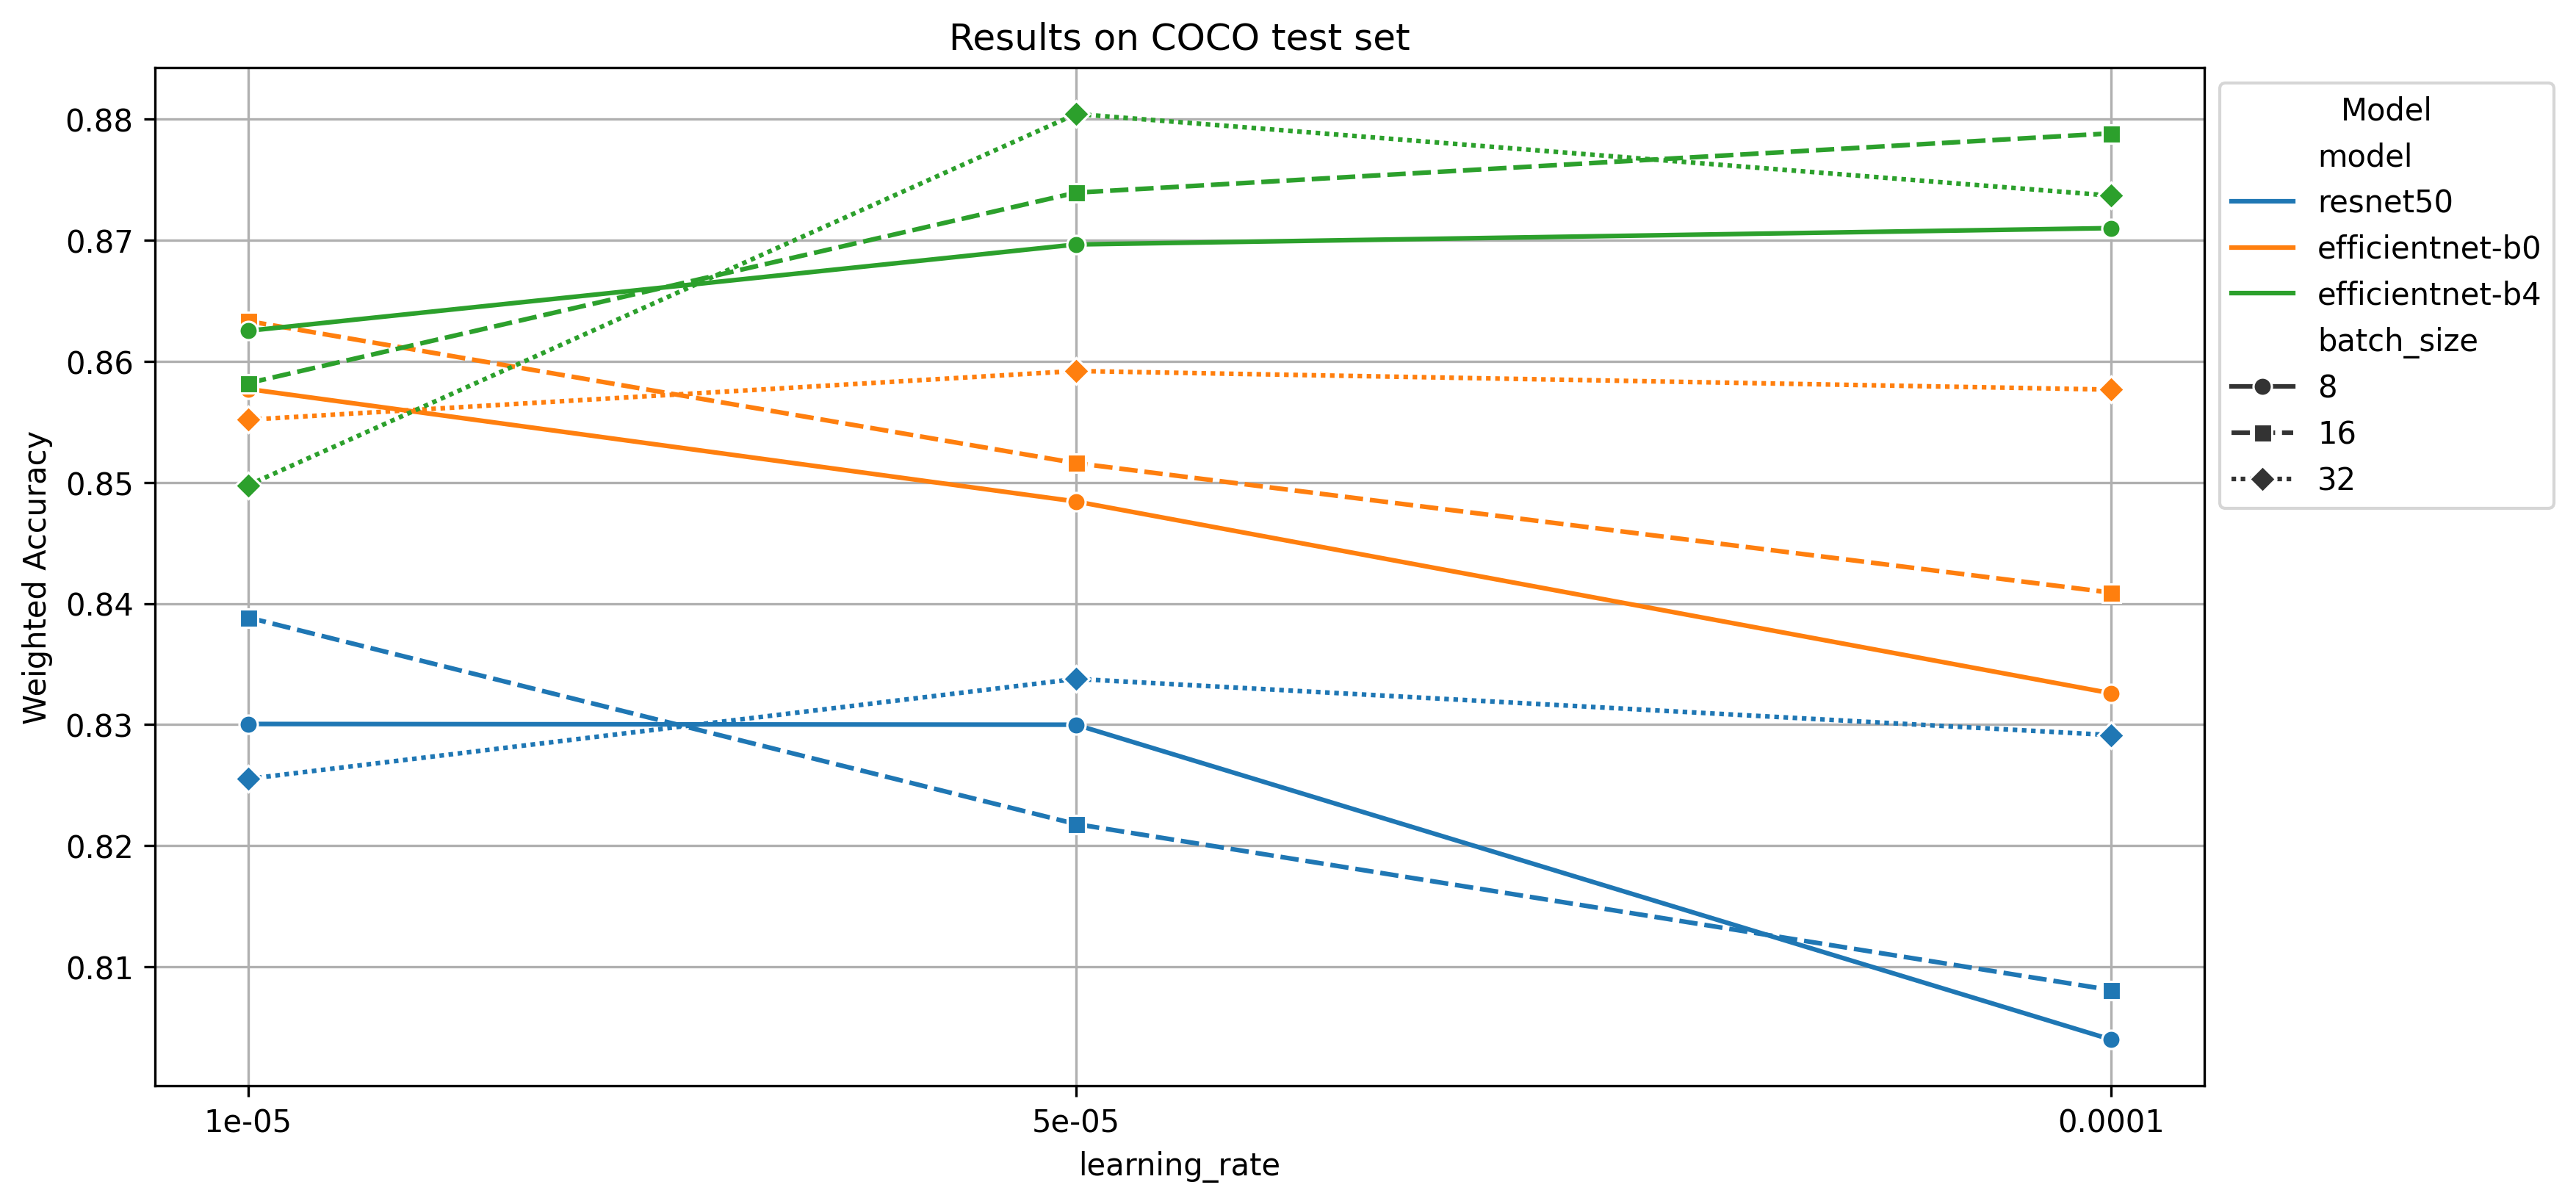

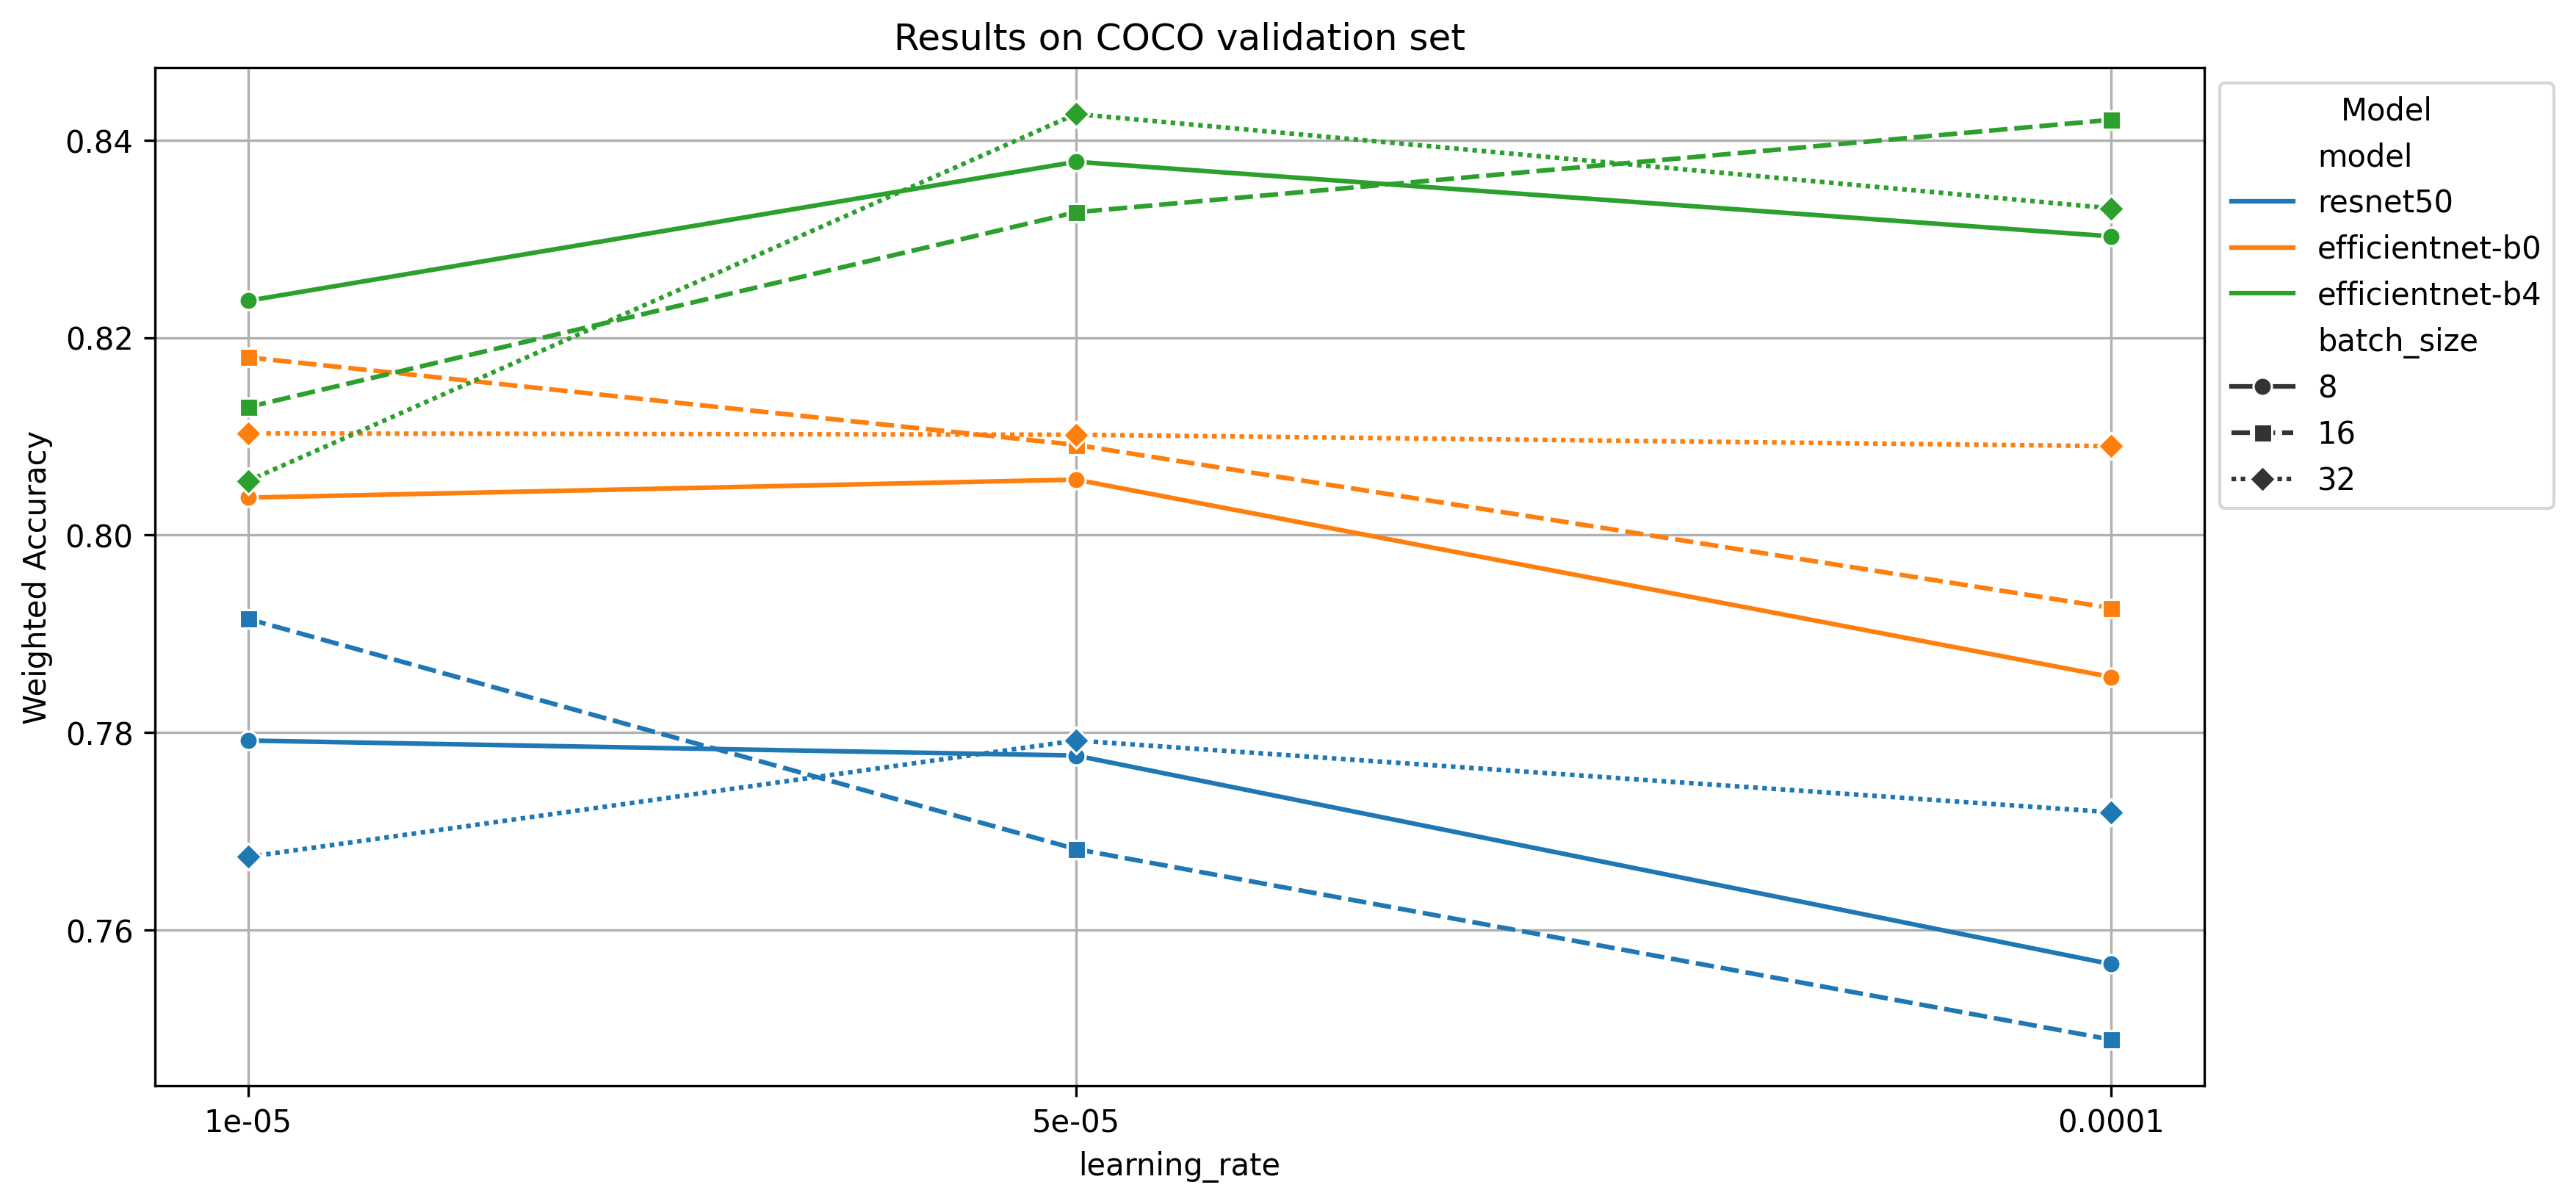

In [26]:
plot_results(df_testset, 'Results on COCO test set', 'learning_rate', 'weighted_acc', 'learning_rate', 'Weighted Accuracy')
plot_results(df_evalset, 'Results on COCO validation set', 'learning_rate', 'weighted_acc', 'learning_rate', 'Weighted Accuracy')

Select the best model and view its confusion matrix

In [20]:
best_model_eval = df_evalset.loc[df_evalset['weighted_f1'].idxmax()]
best_model, best_batch_size, best_learning_rate = best_model_eval['model'], int(best_model_eval['batch_size']), float(best_model_eval['learning_rate'])

model_dir = Path(f'models_coco/{best_model}/{model_time_list[model_name_list.index(best_model)].strftime("%Y%m%d-%H%M%S")}/') / f'bs_{best_batch_size}_lr_{best_learning_rate}'
if not model_dir.exists():
    raise FileNotFoundError(f"Directory {model_dir} does not exist.")

# load the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
y_test = np.load(model_dir / f'y_labels_test.npy')
y_pred_test = np.load(model_dir / f'y_pred_test.npy')
y_eval = np.load(model_dir / f'y_labels_valid.npy')
y_pred_eval = np.load(model_dir / f'y_pred_valid.npy')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8), dpi=300)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Assuming you have a list of class names

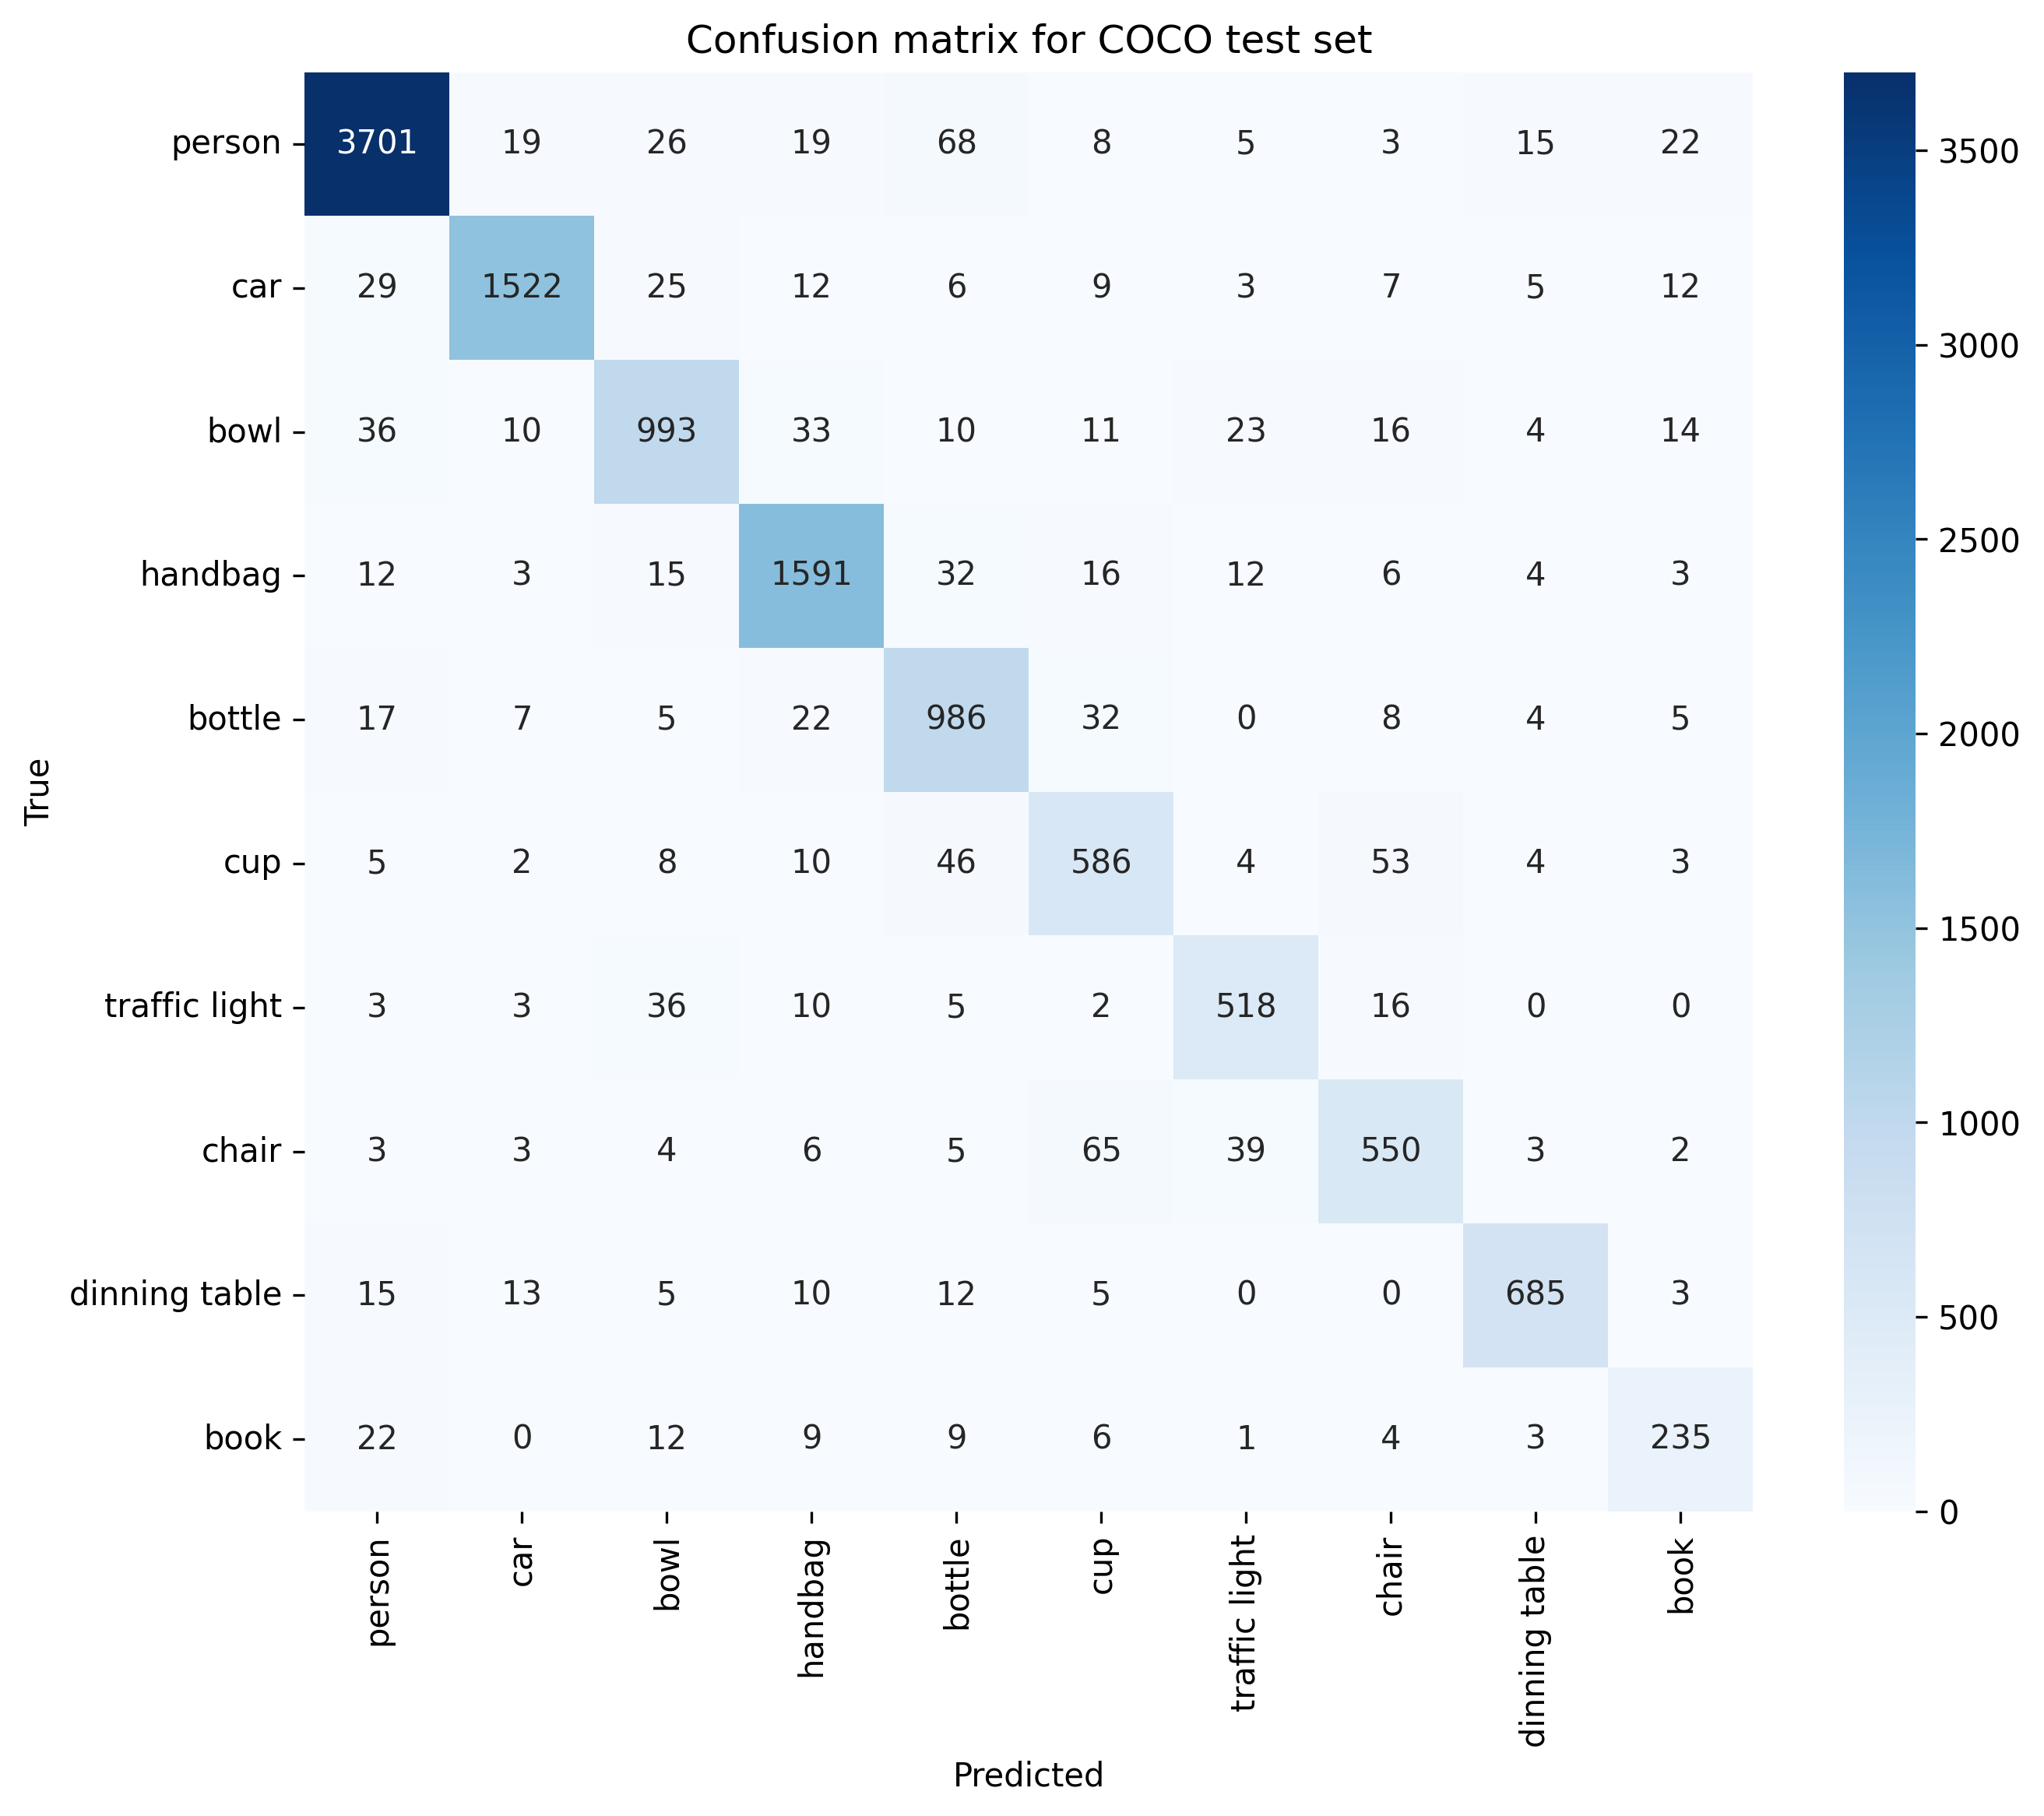

In [23]:
plot_confusion_matrix(y_test, y_pred_test, LABELS, 'Confusion matrix for COCO test set')

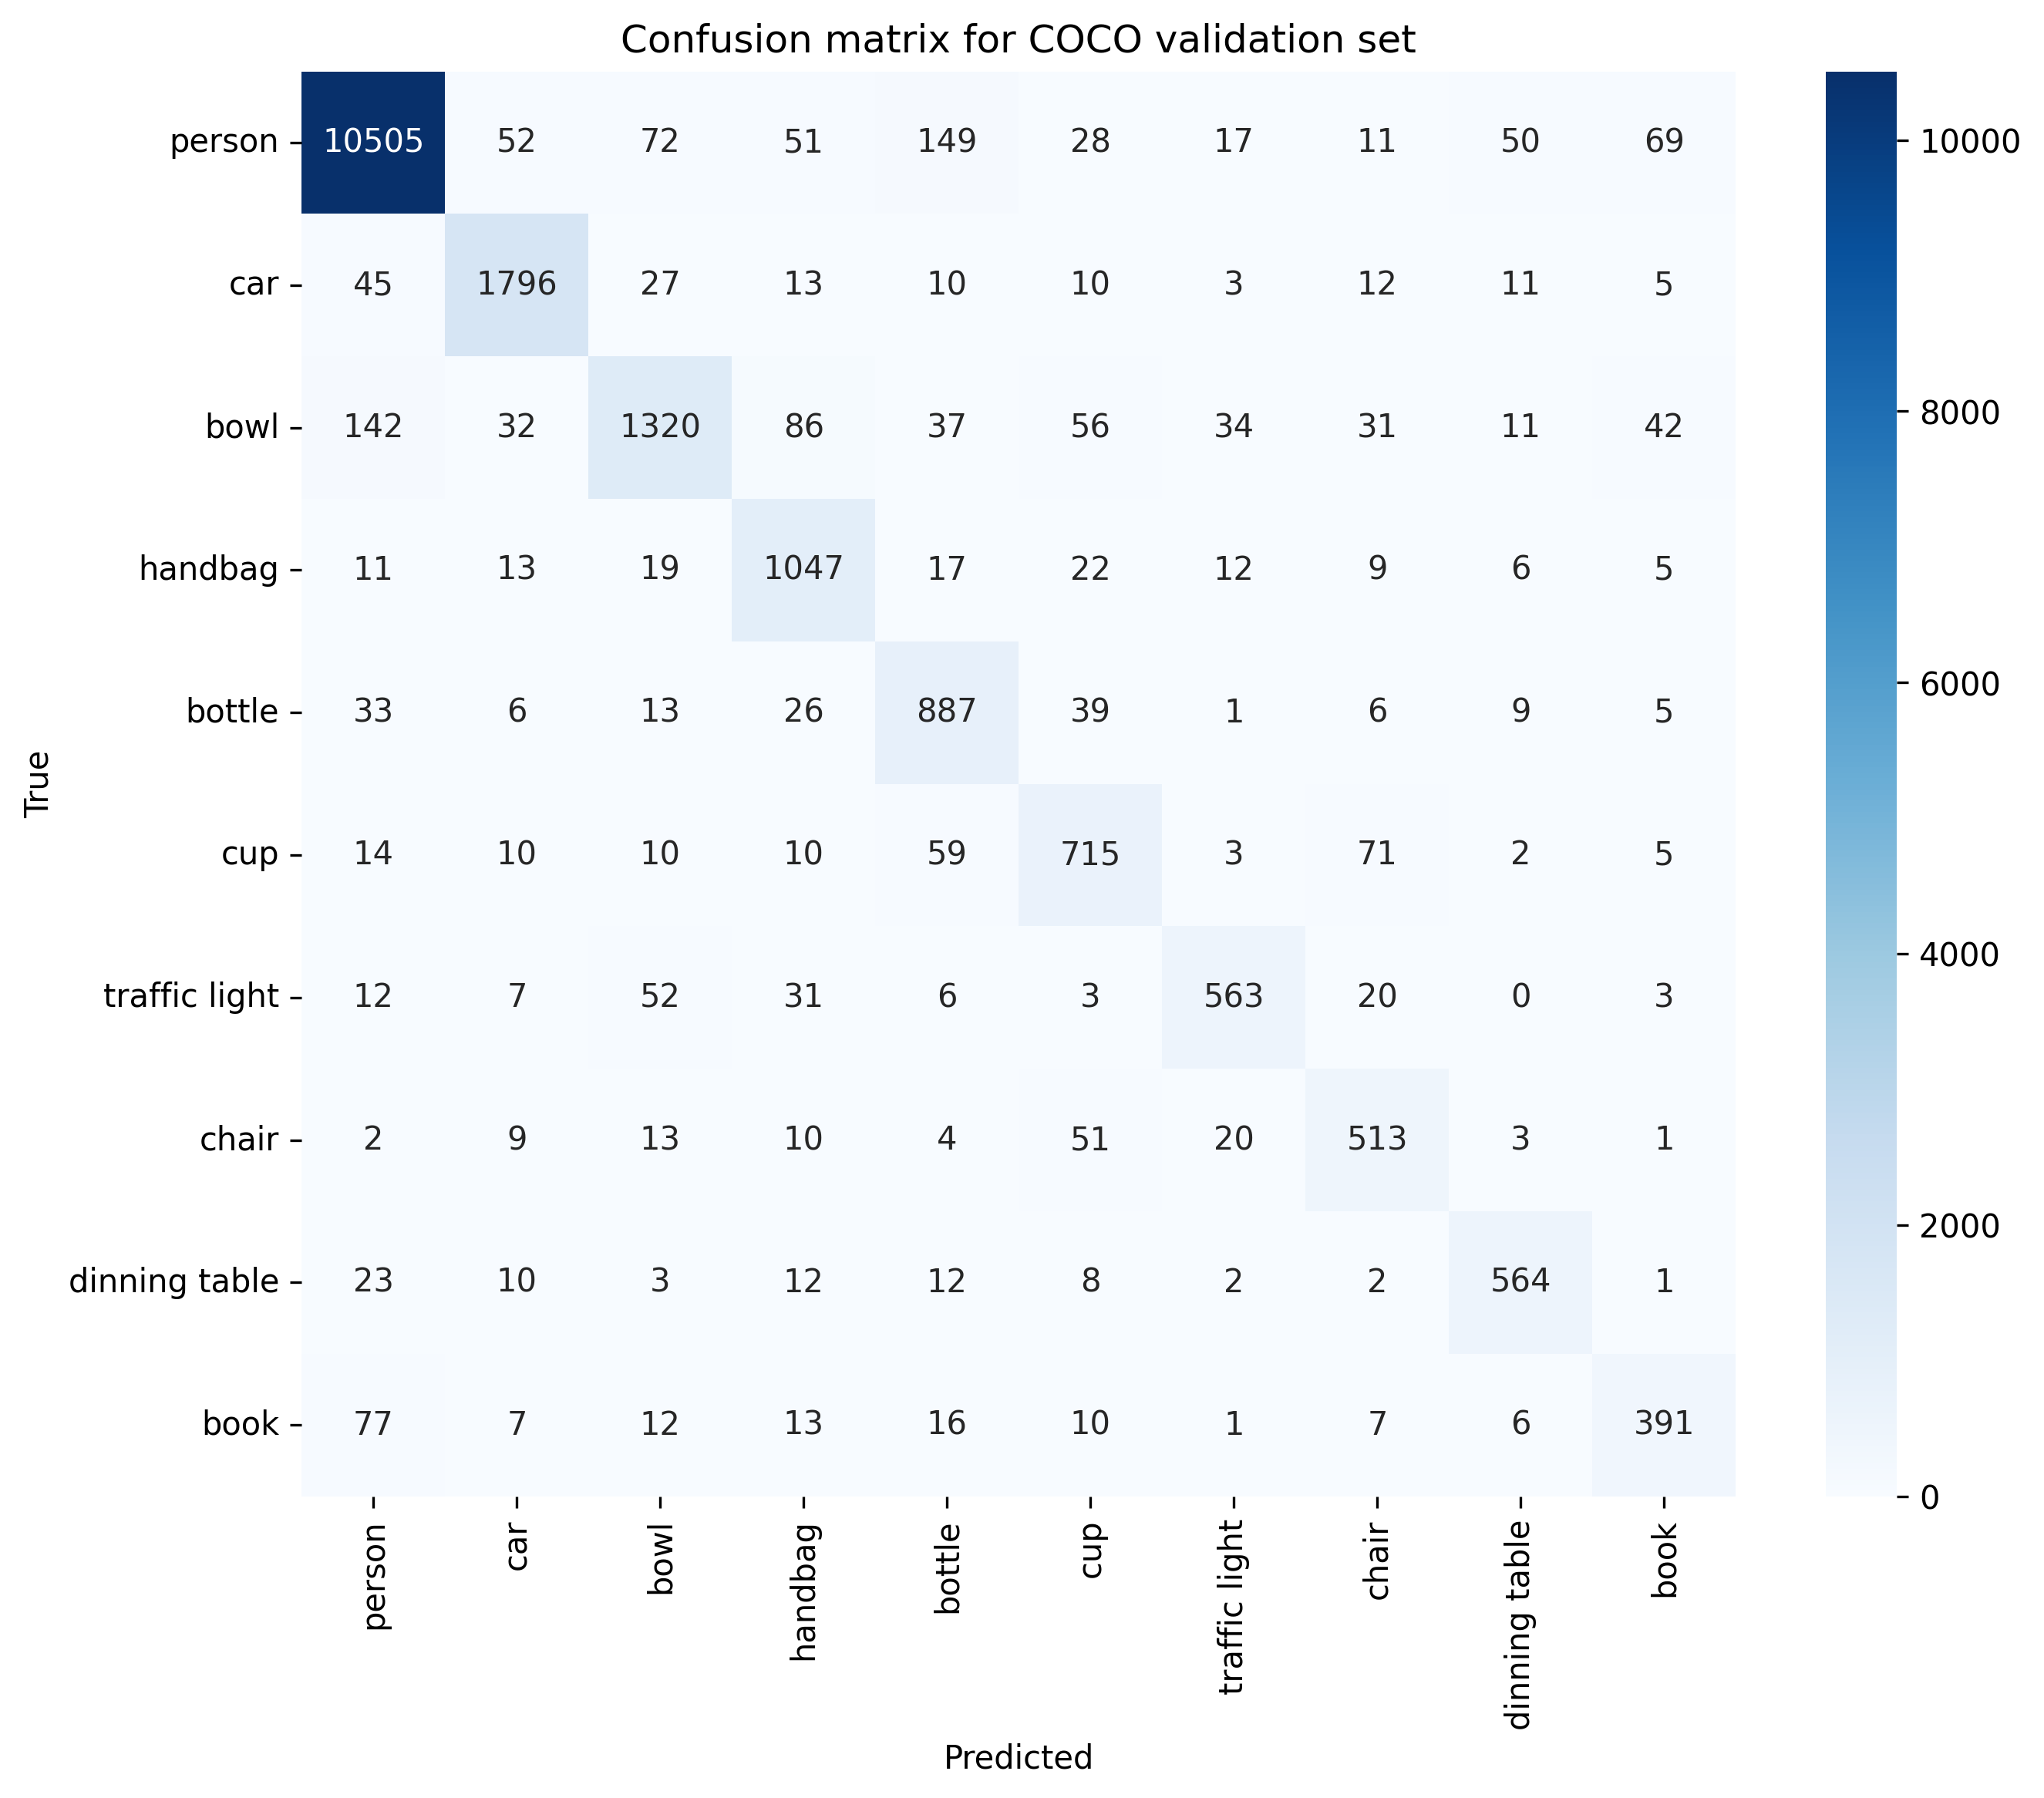

In [24]:
plot_confusion_matrix(y_eval, y_pred_eval, LABELS, 'Confusion matrix for COCO validation set')